# Fine-tunning du modèle tiny deit pour le dataset PCAM d'images tumorales

In [1]:
!pip install --quiet torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time

!pip install --quiet --upgrade "git+https://gitlab.com/robindar/dl-scaman_checker.git"
from dl_scaman_checker import HW01
HW01.check_install(requires="0.7.1")

  Preparing metadata (setup.py) ... done
[DONE] Install ok. Version is v0.7.1


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


#I. Chargement du modèle tiny deit et adaptation à la classification tumorale

In [32]:
## Charger et modifier le modèle Deit pré-entraîné
model_deit = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

# Modifier la dernière couche pour avoir 2 sorties (tumeur vs non-tumeur)
in_features = model_deit.head.in_features
model_deit.head = nn.Linear(in_features, 2)

# Vérifier la nouvelle architecture
print(model_deit)



VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


# Génération du Dataset PCAM et transformation des inputs pour l'adapter à Deit (224px*224px)

In [6]:
## Downlading the data

data_train = HW01.PCAM(root='./data', split='val', download=True)
data_test = HW01.PCAM(root='./data', split='test', download=True)

Using mirror: https://www.robindar.com/pcam-hw01/camelyonpatch_level_2_split_test_x.h5.gz
Using mirror: https://www.robindar.com/pcam-hw01/camelyonpatch_level_2_split_test_y.h5.gz


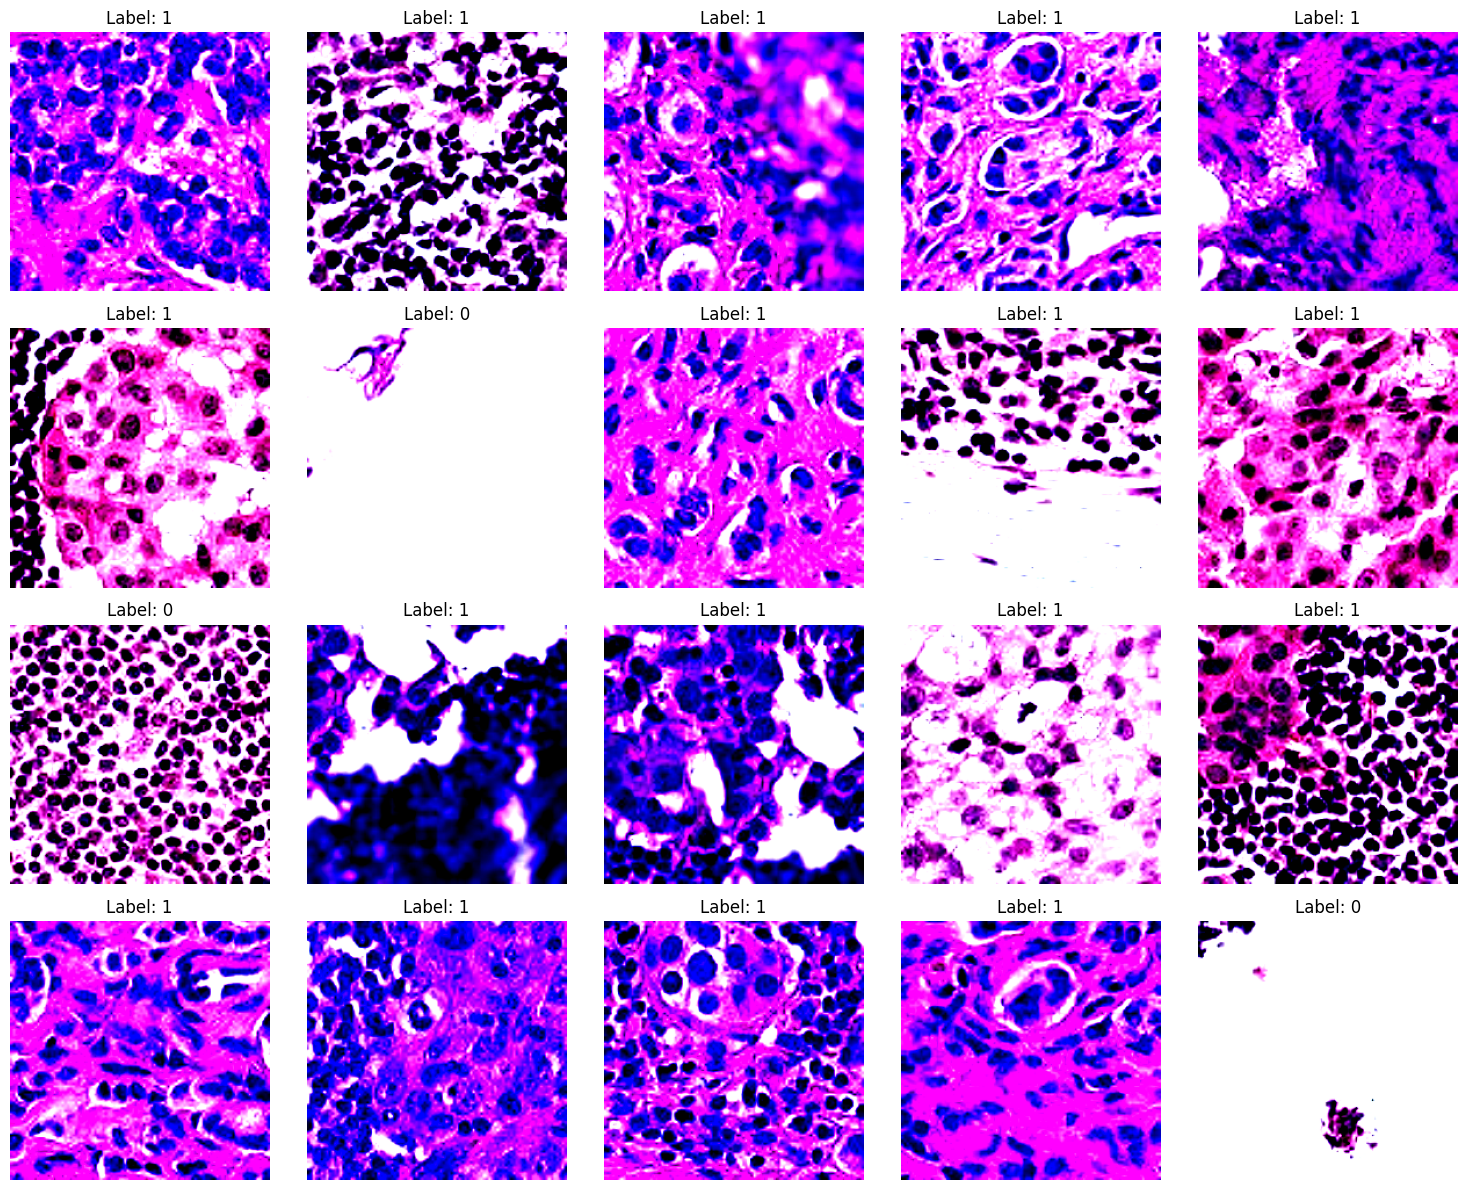

In [33]:
## Afficher des exemples d'images tumorales

# Définir le nombre d'images à afficher et la grille (4 lignes x 5 colonnes)
num_images = 20
rows, cols = 4, 5

fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

for idx in range(num_images):
    row = idx // cols
    col = idx % cols

    image, label = data_train[idx]


    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()

    axes[row, col].imshow(image)
    axes[row, col].set_title(f"Label: {label}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()



On va normaliser les images et les redimensionner en 224px*224px pour l'adapter au modèle Deit.

In [35]:
## Transforming images into tensors

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

data_train.transform = transform
data_test.transform = transform

print("Train set size:", len(data_train))
print("Test set size:", len(data_test))
print()
print("Size of the images in the training test", data_train[0][0].shape)
print("Size of the images in the testing test", data_test[0][0].shape)

Train set size: 32768
Test set size: 32768

Size of the images in the training test torch.Size([3, 224, 224])
Size of the images in the testing test torch.Size([3, 224, 224])


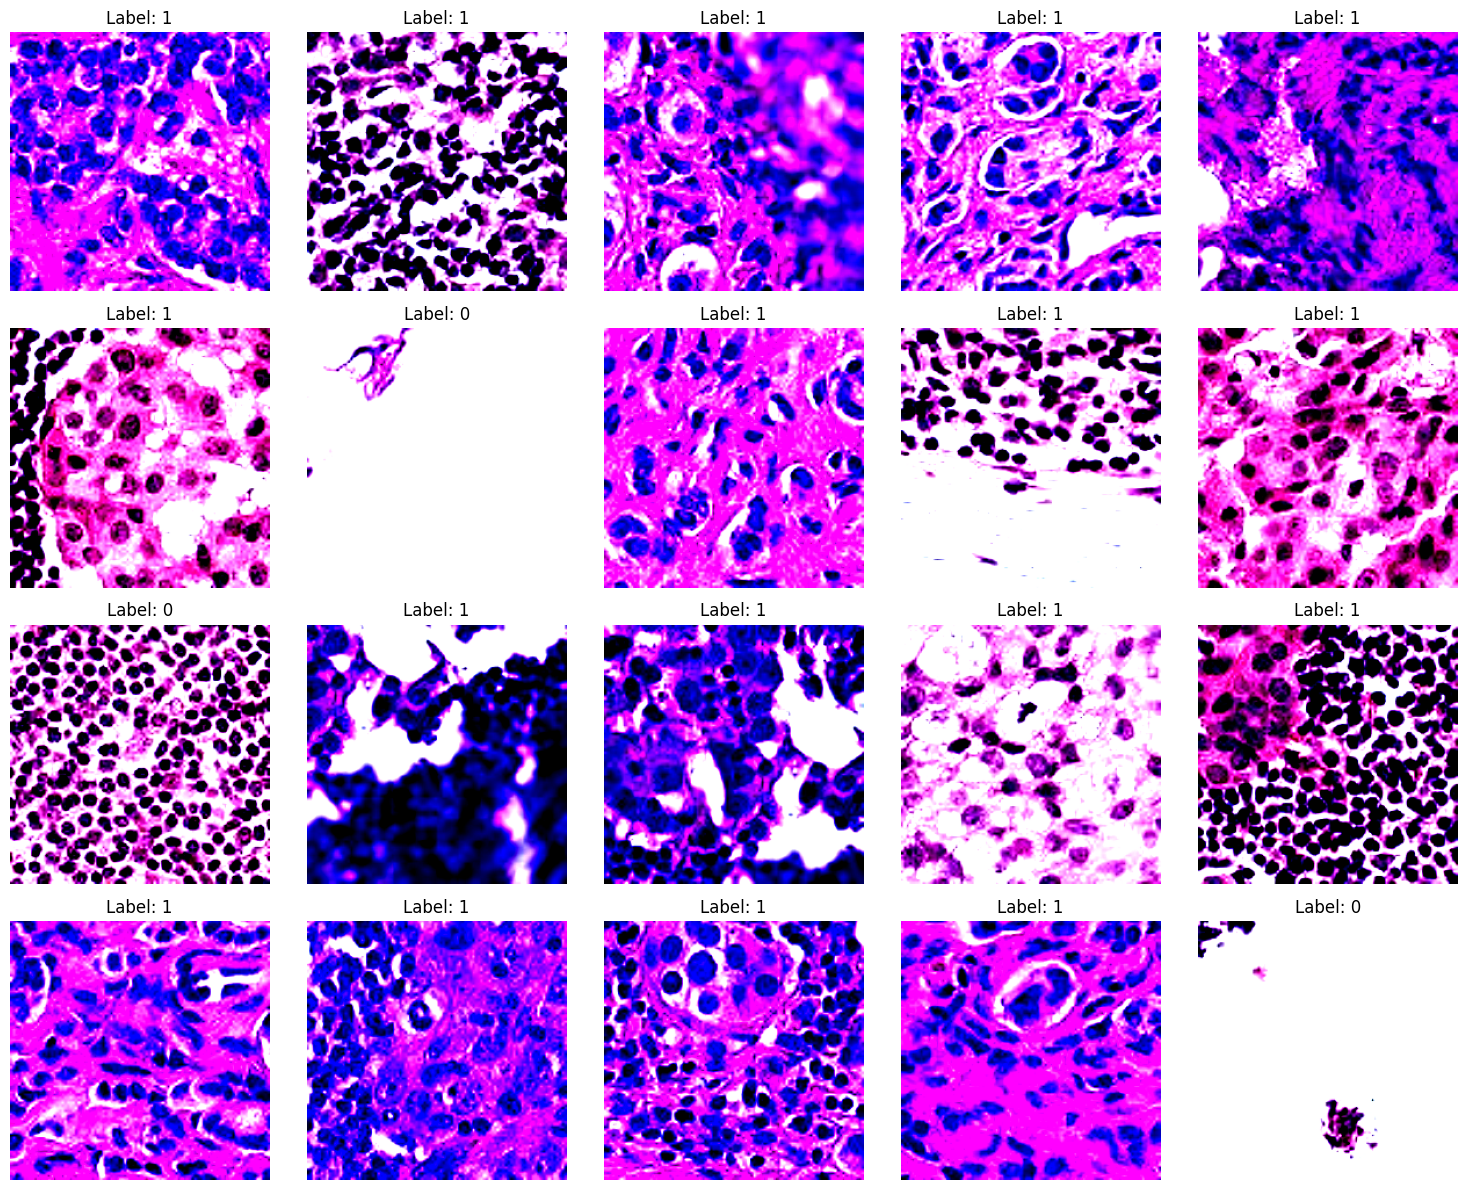

In [36]:
## Afficher des exemples d'images tumorales après redimensionnement et normalisation

# Définir le nombre d'images à afficher et la grille (4 lignes x 5 colonnes)
num_images = 20
rows, cols = 4, 5

fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

for idx in range(num_images):
    row = idx // cols
    col = idx % cols

    image, label = data_train[idx]

    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()

    axes[row, col].imshow(image)
    axes[row, col].set_title(f"Label: {label}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


Maintenant qu'on a les datasets avec les images bien dimensionnées pour Deit, créons les dataloader.

In [37]:
## Creating dataloader

from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

print("Number of mini-batches in the training set:", len(train_loader))
print("Number of mini-batches in the testing set:", len(test_loader))

Number of mini-batches in the training set: 512
Number of mini-batches in the testing set: 512


# Entraînement du modèle Deit sur le dataset PCAM

On a modifié le modèle Deit pour avoir 2 classes (tumeur ou non tumeur), et on a créé les dataloaders depuis le dataset PCAM. Dans un premier temps, on ne vas toucher qu'à la dernière couche (head) et geler tous les autres paramètres du modèle. Pour cela, on va également définir la fonction precompute qui calcule les images jusqu'à l'entrée de cette couche pour gagner en temps de calcul.

In [38]:
from torch.utils.data import TensorDataset, DataLoader

def precompute_deit_tiny_features(model, dataloader):
    model.eval()
    model.to(device)
    list_outputs = []
    list_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            # Utilisation de forward_features pour extraire les représentations intermédiaires
            features = model.forward_features(inputs)
            list_outputs.append(features)
            list_labels.append(labels)

    outputs = torch.cat(list_outputs, dim=0)
    labels = torch.cat(list_labels, dim=0)

    return TensorDataset(outputs, labels)



Pour être certains de ne pas toucher aux autres paramètres, on gèle tous les poids en dehors de la dernière couche.

In [39]:
# Geler tous les paramètres
for param in model_deit.parameters():
    param.requires_grad = False

# Réactiver la mise à jour pour la dernière couche (par exemple, model_deit.head)
for param in model_deit.head.parameters():
    param.requires_grad = True


On va calculer les sorties qui ne changeront pas (avant l'entrée de la tête head) avec la fonction precompute.

In [43]:

torch.cuda.empty_cache()
torch.cuda.ipc_collect()



In [42]:
# Maintenant, vous pouvez pré-calculer les features


precomputed_train_dataset = precompute_deit_tiny_features(model_deit, train_loader)
precomputed_test_dataset = precompute_deit_tiny_features(model_deit, test_loader)

precomputed_train_loader = DataLoader(precomputed_train_dataset, batch_size=batch_size, shuffle=True)
precomputed_test_loader = DataLoader(precomputed_test_dataset, batch_size=batch_size, shuffle=False)

OutOfMemoryError: CUDA out of memory. Tried to allocate 38.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 38.12 MiB is free. Process 2589 has 14.70 GiB memory in use. Of the allocated memory 14.39 GiB is allocated by PyTorch, and 185.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [17]:
features, labels = precomputed_train_dataset[:5]  # Vérifier les 5 premiers
print(f"Taille d'un sample feature : {features.shape}")
print(f"Taille d'un sample label : {labels.shape}")


Taille d'un sample feature : torch.Size([5, 197, 192])
Taille d'un sample label : torch.Size([5])


La tête de classification (head) s'attend à une entrée de shape (batch_size, 192), pas (batch_size, 197, 192).
On doit donc extraire uniquement le token [CLS], qui se trouve en position 0 (features[:, 0, :]), et qui sert à agréger l'information des autres tokens.

In [18]:
for param in model_deit.parameters():
    param.requires_grad = False  # On gèle tout
for param in model_deit.head.parameters():
    param.requires_grad = True  # On entraîne seulement la tête


## Entraînement de la tête sur nos dataloaders

In [19]:
## Définition de l'optimizer et de la loss

optimizer = torch.optim.SGD(model_deit.head.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import torch.optim as optim

# 🔹 Initialisation
num_epochs = 10  # Peut être ajusté
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_deit.head.parameters(), lr=0.0005)  # Petit LR pour stabiliser l'apprentissage

# 🔹 Listes pour le suivi
train_losses, val_losses = [], []
train_accuracies, val_accuracies = []
f1_scores = []  # F1-score à chaque epoch

# 🔹 Boucle d'entraînement
for epoch in range(num_epochs):
    model_deit.head.train()
    running_loss, correct_preds, total = 0.0, 0, 0

    for features, labels in precomputed_train_loader:
        features, labels = features.to(device), labels.to(device)
        features = features[:, 0, :]  # Sélection du token CLS

        optimizer.zero_grad()
        outputs = model_deit.head(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct_preds += torch.sum(preds == labels).item()
        total += labels.size(0)

    # 🔹 Calcul des métriques sur train
    train_loss = running_loss / total
    train_acc = correct_preds / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # 🔹 Évaluation sur validation
    model_deit.head.eval()
    val_loss, correct_preds, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for features, labels in precomputed_test_loader:
            features, labels = features.to(device), labels.to(device)
            features = features[:, 0, :]  # Sélection du token CLS

            outputs = model_deit.head(features)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * labels.size(0)
            preds = torch.argmax(outputs, dim=1)

            correct_preds += torch.sum(preds == labels).item()
            total += labels.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    # 🔹 Calcul des métriques sur validation
    val_loss = val_loss / total
    val_acc = correct_preds / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # 🔹 Calcul du F1-score
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    f1 = f1_score(all_labels, all_preds, average="binary")  # "binary" car 2 classes
    f1_scores.append(f1)

    print(f"📊 Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4%} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4%} | F1: {f1:.4f}")

print("✅ Entraînement terminé !")



In [ ]:
# 📉 Courbe de perte
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Évolution de la Loss")

# 📈 Courbe d'accuracy
plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker="o")
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Évolution de l'Accuracy")

plt.show()


In [ ]:
# 📊 Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Tumoral", "Tumoral"], yticklabels=["Non-Tumoral", "Tumoral"])
plt.xlabel("Prédictions")
plt.ylabel("Vraies Classes")
plt.title("Matrice de Confusion")
plt.show()

# 📑 Rapport de classification
print("\n📊 **Rapport de Classification**:\n", classification_report(all_labels, all_preds, target_names=["Non-Tumoral", "Tumoral"]))


## Ceci était le premier entraînement. Je l'ai refait en plus rigoureux.

In [20]:
num_epochs = 2

model_deit.head.train()
for epoch in range(num_epochs):
    for features, labels in precomputed_train_loader:
        # Déplacement sur GPU
        features = features.to(device)
        labels = labels.to(device)

        # Sélection du token [CLS]
        features = features[:, 0, :]  # Shape devient (batch_size, 192)

        optimizer.zero_grad()
        # Passage direct dans la tête
        outputs = model_deit.head(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()




<ipython-input-20-9b68ae69d513>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_deit.load_state_dict(torch.load("deit_tiny_full.pth"))


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


In [23]:
def test_model_head(model, dataloader):
    model.to(device)
    model.eval()  # Mode évaluation
    running_loss, running_acc = 0., 0
    n_data = len(dataloader.dataset)
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for features, targets in dataloader:
            features, targets = features.to(device), targets.to(device)

            # Sélection du token [CLS]
            features = features[:, 0, :]  # Shape devient (batch_size, 192)

            # Passage dans la tête seulement
            outputs = model.head(features)
            loss = criterion(outputs, targets)

            preds = torch.argmax(outputs, dim=1)
            running_loss += loss.item()
            running_acc += torch.sum(preds == targets).item()

    # Calcul des valeurs moyennes
    loss_value = running_loss / n_data
    acc_value = running_acc / n_data

    # Affichage des résultats
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.bar("Loss", loss_value, color="tab:red", width=0.4)
    ax1.set_ylabel("Loss", color="tab:red")
    ax1.tick_params(axis="y", labelcolor="tab:red")

    ax2.bar("Accuracy", acc_value, color="tab:blue", width=0.4)
    ax2.set_ylabel("Accuracy (%)", color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    plt.title("Loss and Accuracy on Test Set")
    plt.show()

    print(f"Test Loss: {loss_value:.4f}")
    print(f"Test Accuracy: {acc_value:.4%}")

    return loss_value, acc_value


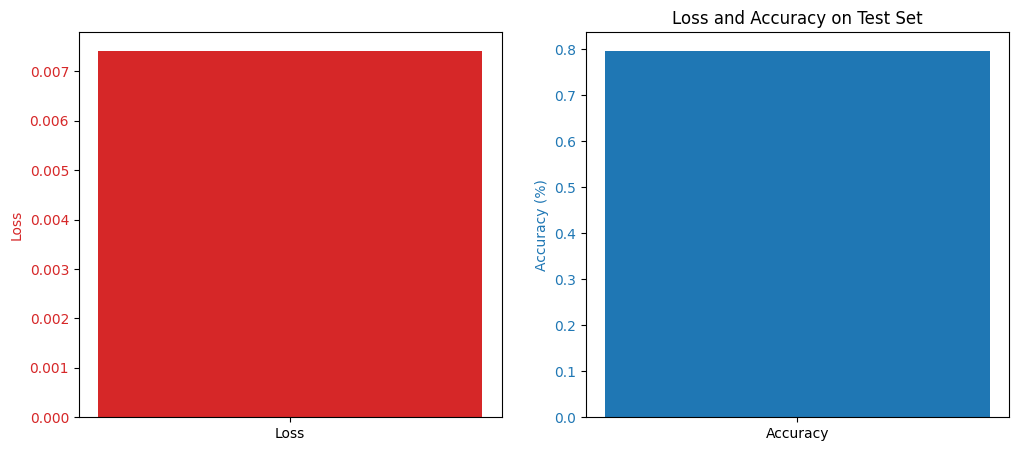

Test Loss: 0.0074
Test Accuracy: 79.6570%


In [24]:
test_loss, test_acc = test_model_head(model_deit, precomputed_test_loader)


In [26]:
## On va améliorer le modèle encore

num_epochs = 10  # Augmentez le nombre d'epochs

model_deit.head.train()  # Assurez-vous que la tête est en mode entraînement
for epoch in range(num_epochs):
    for features, labels in precomputed_train_loader:
        # Déplacement sur GPU
        features = features.to(device)
        labels = labels.to(device)

        # Sélection du token [CLS]
        features = features[:, 0, :]  # Shape devient (batch_size, 192)

        optimizer.zero_grad()
        # Passage direct dans la tête
        outputs = model_deit.head(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


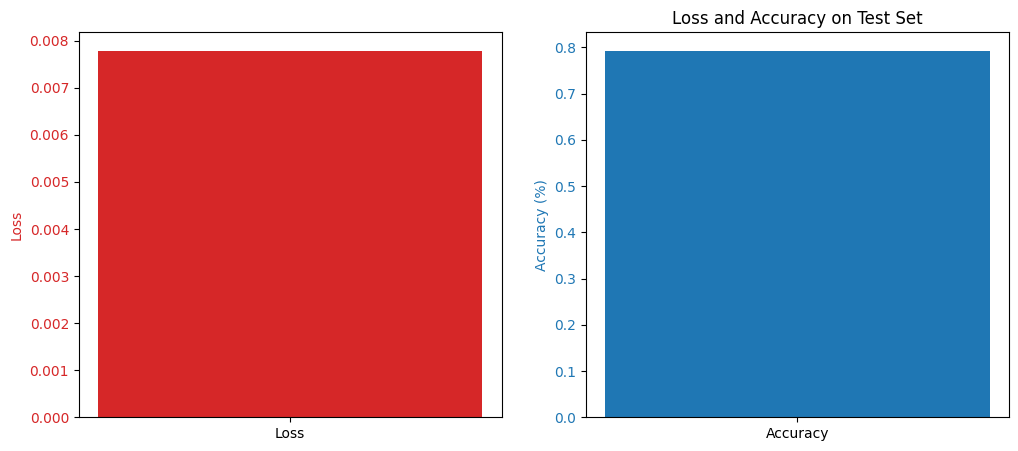

Test Loss: 0.0078
Test Accuracy: 79.2999%


In [27]:
test_loss, test_acc = test_model_head(model_deit, precomputed_test_loader)

In [28]:
optimizer = torch.optim.SGD(model_deit.head.parameters(), lr=0.0001, momentum=0.9)
model_deit.head.train()  # Assurez-vous que la tête est en mode entraînement
for epoch in range(num_epochs):
    for features, labels in precomputed_train_loader:
        # Déplacement sur GPU
        features = features.to(device)
        labels = labels.to(device)

        # Sélection du token [CLS]
        features = features[:, 0, :]  # Shape devient (batch_size, 192)

        optimizer.zero_grad()
        # Passage direct dans la tête
        outputs = model_deit.head(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()



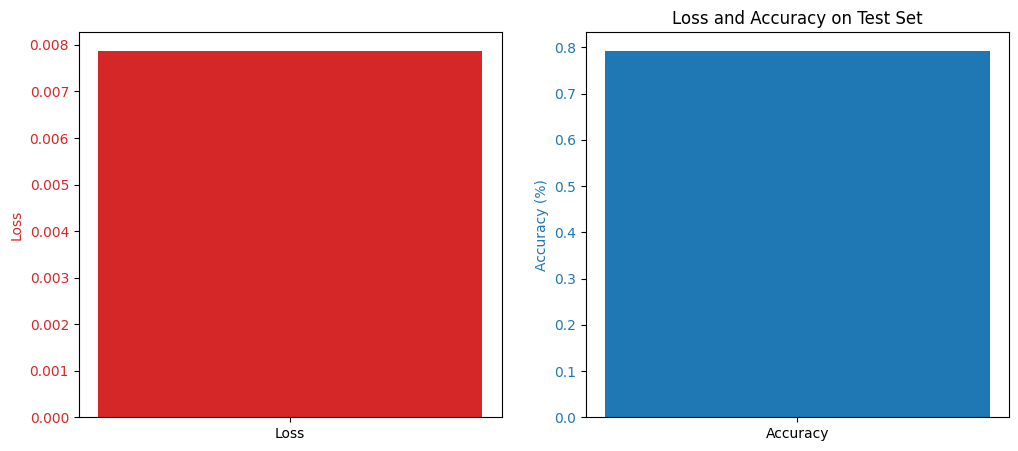

Test Loss: 0.0079
Test Accuracy: 79.3030%


In [29]:
test_loss, test_acc = test_model_head(model_deit, precomputed_test_loader)

In [30]:
from sklearn.metrics import classification_report, f1_score

def evaluate_model(model, dataloader):
    model.to(device)
    model.eval()  # Mettre en mode évaluation
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)

            # Sélection du token [CLS]
            features = features[:, 0, :]  # Shape devient (batch_size, 192)

            # Passage dans la tête
            outputs = model.head(features)
            preds = torch.argmax(outputs, dim=1)  # Classe prédite

            all_preds.append(preds.cpu())  # Déplacer sur CPU pour sklearn
            all_labels.append(labels.cpu())

    # Convertir en tenseurs numpy
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Calcul du F1-Score et du rapport complet
    f1 = f1_score(all_labels, all_preds, average="binary")  # "binary" pour 2 classes
    report = classification_report(all_labels, all_preds, target_names=["Non-Tumoral", "Tumoral"])

    print(f"\n🔹 **F1-Score**: {f1:.4f}")
    print("\n📊 **Rapport de Classification**:\n", report)

    return f1

# 📌 Lancer l'évaluation
f1_test = evaluate_model(model_deit, precomputed_test_loader)



🔹 **F1-Score**: 0.7797

📊 **Rapport de Classification**:
               precision    recall  f1-score   support

 Non-Tumoral       0.76      0.85      0.80     16391
     Tumoral       0.83      0.73      0.78     16377

    accuracy                           0.79     32768
   macro avg       0.80      0.79      0.79     32768
weighted avg       0.80      0.79      0.79     32768

